## The dataset was taken from Kaggle [Brain MRI Images for Brain Tumor Detection](https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection).

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip gdrive/MyDrive/Data/MRI.zip

Archive:  gdrive/MyDrive/Data/MRI.zip
  inflating: brain_tumor_dataset/no/1 no.jpeg  
  inflating: brain_tumor_dataset/no/10 no.jpg  
  inflating: brain_tumor_dataset/no/11 no.jpg  
  inflating: brain_tumor_dataset/no/12 no.jpg  
  inflating: brain_tumor_dataset/no/13 no.jpg  
  inflating: brain_tumor_dataset/no/14 no.jpg  
  inflating: brain_tumor_dataset/no/15 no.jpg  
  inflating: brain_tumor_dataset/no/17 no.jpg  
  inflating: brain_tumor_dataset/no/18 no.jpg  
  inflating: brain_tumor_dataset/no/19 no.jpg  
  inflating: brain_tumor_dataset/no/2 no.jpeg  
  inflating: brain_tumor_dataset/no/20 no.jpg  
  inflating: brain_tumor_dataset/no/21 no.jpg  
  inflating: brain_tumor_dataset/no/22 no.jpg  
  inflating: brain_tumor_dataset/no/23 no.jpg  
  inflating: brain_tumor_dataset/no/24 no.jpg  
  inflating: brain_tumor_dataset/no/25 no.jpg  
  inflating: brain_tumor_dataset/no/26 no.jpg  
  inflating: brain_tumor_dataset/no/27 no.jpg  
  inflating: brain_tumor_dataset/no/28 no.jpg  
  

In [ ]:
import os

dataset_path = 'brain_tumor_dataset'

paths = []
labels = []

for label in ['yes','no']:
    for dirname, _, filenames in os.walk(os.path.join(dataset_path,label)):
        for filename in filenames:
            paths.append(os.path.join(dirname, filename))
            labels.append(1 if label == 'yes' else 0)

len(paths), len(labels)

(253, 253)

In [ ]:
import cv2

sizes = []
for path in paths:
    img = cv2.imread(path)
    if img is not None:
        height, width, _ = img.shape
        sizes.append((width, height))
    else:
        print(f"Failed to read image at path: {path}")

if sizes:
    max_size = max(sizes)
    min_size = min(sizes)
    print("Max size:", max_size)
    print("Min size:", min_size)
else:
    print("No valid images found.")

Max size: (1920, 1080)
Min size: (150, 198)


In [ ]:
from sklearn.model_selection import train_test_split

# Splitting paths to images into training and test sets
X_train, X_test, y_train, y_test = train_test_split(paths,  # Paths to images
                                                    labels,  # Class labels
                                                    test_size=0.05,  # Size of test set (5%)
                                                    shuffle=True,  # Shuffle data before splitting
                                                    random_state=1357  # Fix random number generator for reproducibility
                                                   )

# Further splitting the remaining dataset (X_train and y_train) into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train,  # Paths to images (training set)
                                                  y_train,  # Class labels (training set)
                                                  test_size=0.25,  # Size of validation set (25% of X_train and y_train)
                                                  shuffle=True,  # Shuffle data before splitting
                                                  random_state=42  # Fix random number generator for reproducibility
                                                 )

# Printing sizes of training, validation, and test sets
print("Size of training set:", len(X_train))
print("Size of validation set:", len(X_val))
print("Size of test set:", len(X_test))

Size of training set: 180
Size of validation set: 60
Size of test set: 13


In [ ]:
import cv2
from torchvision import transforms
import numpy as np
from PIL import Image

class MRIDataset():
    def __init__(self, paths, labels, augmentations=None):
        self.paths = paths
        self.labels = labels

        if augmentations is None:
            self.augmentations = transforms.Compose([transforms.ToTensor()])
        else:
            self.augmentations = augmentations

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, index):

        label = self.labels[index]

        sample = cv2.imread(self.paths[index])
        sample = cv2.cvtColor(sample, cv2.COLOR_BGR2RGB)
        sample = Image.fromarray(sample)

        if self.augmentations:
            sample = self.augmentations(sample)
        else:
            sample = transforms.ToTensor()(sample)

        return (sample, torch.tensor(label, dtype=torch.float))

In [ ]:
train_augmentations = transforms.Compose([transforms.Resize((224,224)),
                                          transforms.RandomHorizontalFlip(0.2),
                                          transforms.RandomVerticalFlip(0.1),
                                          transforms.RandomAutocontrast(0.2),
                                          transforms.RandomAdjustSharpness(0.3),
                                          transforms.ToTensor()
                                         ])

test_augmentations = transforms.Compose([transforms.Resize((224,224)),
                                          transforms.RandomHorizontalFlip(0.2),
                                          transforms.RandomVerticalFlip(0.1),
                                          transforms.RandomAutocontrast(0.2),
                                          transforms.RandomAdjustSharpness(0.3),
                                          transforms.ToTensor()
                                         ])

valid_augmentations = transforms.Compose([transforms.Resize((224,224)),
                                          transforms.ToTensor()
                                         ])

train_dataset = MRIDataset(X_train, y_train, augmentations=train_augmentations)
test_dataset = MRIDataset(X_test, y_test, augmentations=test_augmentations)
valid_dataset = MRIDataset(X_val, y_val, augmentations=valid_augmentations)

torch.Size([3, 224, 224])
1.0


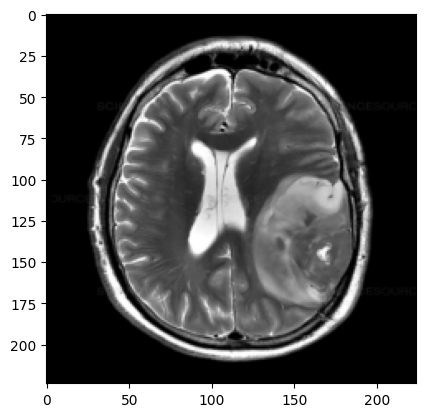

In [ ]:
import matplotlib.pyplot as plt
import torch

random_sample, random_label = test_dataset[0]
print(random_sample.shape)
plt.imshow(random_sample.permute(1,2,0))
print(random_label.item())

In [ ]:
import torch
from torch.utils.data import DataLoader

class Config:
    learning_rate = 1e-3
    epochs = 10
    train_batch_size = 8
    test_batch_size = 8
    valid_batch_size = 8


train_dataloader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size=Config.train_batch_size,
                                               shuffle=True,
                                               num_workers=2)

test_dataloader = torch.utils.data.DataLoader(test_dataset,
                                              batch_size=Config.test_batch_size,
                                              shuffle=True,
                                              num_workers=2)

valid_dataloader = torch.utils.data.DataLoader(valid_dataset,
                                               batch_size=Config.valid_batch_size,
                                               shuffle=False,
                                               num_workers=2)


len(train_dataloader), len(test_dataloader), len(valid_dataloader)

(23, 2, 8)

In [ ]:
import torch.nn as nn

class Model(nn.Module):

    def __init__(self, in_features=3):
        super(Model, self).__init__()


        self.conv_block = nn.Sequential(nn.Conv2d(in_channels=in_features,
                                                 out_channels=32,
                                                 kernel_size=3,
                                                 stride=1
                                                 ),
                                       nn.ReLU(),
                                       nn.MaxPool2d(2,2),

                                       nn.Conv2d(in_channels=32,
                                                 out_channels=64,
                                                 kernel_size=3,
                                                 stride=1
                                                ),
                                       nn.ReLU(),
                                       nn.MaxPool2d(2,2)
                                      )

        self.linear_block = nn.Sequential(nn.Linear(64*54*54, 1024),
                                          nn.ReLU(),
                                          nn.Dropout(0.25),
                                          nn.Linear(1024,256),
                                          nn.ReLU(),
                                          nn.Dropout(0.15),
                                          nn.Linear(256,1)
                                         )


    def forward(self,x):
        x = self.conv_block(x)
        x = torch.flatten(x,1)
        x = self.linear_block(x)
        return x

model = Model()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0.001)

print(model)

Model(
  (conv_block): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_block): Sequential(
    (0): Linear(in_features=186624, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.25, inplace=False)
    (3): Linear(in_features=1024, out_features=256, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.15, inplace=False)
    (6): Linear(in_features=256, out_features=1, bias=True)
  )
)


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

In [ ]:
class SaveBestModelCallback:
    def __init__(self, model, save_path):
        self.model = model
        self.save_path = save_path
        self.best_validation_loss = float('inf')

    def __call__(self, validation_loss):
        if validation_loss < self.best_validation_loss:
            self.best_validation_loss = validation_loss
            torch.save(self.model.state_dict(), self.save_path)
            print("Model weights saved due to improvement in validation loss.")

In [ ]:
class Trainer:
    def __init__(self, model, dataloaders, Config, save_path):
        self.model = model
        self.train_loader, self.valid_loader, self.test_loader = dataloaders
        self.Config = Config
        self.optim = torch.optim.Adam(self.model.parameters(), lr=self.Config.learning_rate)
        self.loss_fn = nn.BCEWithLogitsLoss()
        self.save_path = save_path
        self.best_validation_loss = float('inf')

    def binary_accuracy(self, outputs, labels):
        return (torch.round(torch.sigmoid(outputs)) == labels).sum().item() / labels.shape[0]

    def train_one_epoch(self):
        running_loss = 0
        running_acc = 0

        for X, y in self.train_loader:
            X = X.to(device, dtype=torch.float)
            y = y.reshape(y.shape[0], 1).to(device, dtype=torch.float)

            self.optim.zero_grad()
            outputs = self.model(X)
            loss = self.loss_fn(outputs, y)

            loss.backward()
            self.optim.step()

            running_loss += loss.item()
            running_acc += self.binary_accuracy(outputs, y)

            del X, y
            torch.cuda.empty_cache()

        train_loss = running_loss / len(self.train_loader)
        train_acc = running_acc / len(self.train_loader)
        return train_loss, train_acc

    def validate(self):
        self.model.eval()
        running_loss = 0
        running_acc = 0

        with torch.no_grad():
            for X, y in self.valid_loader:
                X = X.to(device, dtype=torch.float)
                y = y.reshape(y.shape[0], 1).to(device, dtype=torch.float)

                outputs = self.model(X)
                loss = self.loss_fn(outputs, y)

                running_loss += loss.item()
                running_acc += self.binary_accuracy(outputs, y)

                del X, y
                torch.cuda.empty_cache()

            valid_loss = running_loss / len(self.valid_loader)
            valid_acc = running_acc / len(self.valid_loader)
        return valid_loss, valid_acc

    def fit(self):
        train_losses = []
        train_accuracies = []
        valid_losses = []
        valid_accuracies = []

        for epoch in range(self.Config.epochs):
            self.model.train()

            train_loss, train_acc = self.train_one_epoch()
            train_losses.append(train_loss)
            train_accuracies.append(train_acc)

            valid_loss, valid_acc = self.validate()
            valid_losses.append(valid_loss)
            valid_accuracies.append(valid_acc)

            print(f"EPOCH {epoch+1}/{self.Config.epochs}")
            print(f"Training Loss: {train_loss} | Training Accuracy: {train_acc}")
            print(f"Validation Loss: {valid_loss} | Validation Accuracy: {valid_acc}\n\n")

            if valid_loss < self.best_validation_loss and valid_acc >= train_acc:
                torch.save(self.model.state_dict(), self.save_path)
                print("Model weights saved due to improvement in validation loss and no overfitting.")
                self.best_validation_loss = valid_loss

        return train_losses, train_accuracies, valid_losses, valid_accuracies

    @torch.no_grad()
    def test(self):
        self.model.eval()
        running_acc = 0

        for X, y in self.test_loader:
            X = X.to(device, dtype=torch.float)
            y = y.reshape(y.shape[0], 1).to(device, dtype=torch.float)

            outputs = self.model(X)
            running_acc += self.binary_accuracy(outputs, y)

            del X, y
            torch.cuda.empty_cache()

        accuracy = running_acc / len(self.test_loader)
        return accuracy

In [ ]:
save_path = 'model_weights.pth'
trainer = Trainer(model, (train_dataloader, valid_dataloader, test_dataloader), Config, save_path)
train_losses, train_accuracies, valid_losses, valid_accuracies = trainer.fit()

EPOCH 1/10
Training Loss: 1.2072838933571526 | Training Accuracy: 0.5597826086956522
Validation Loss: 0.569853886961937 | Validation Accuracy: 0.78125


Model weights saved due to improvement in validation loss and no overfitting.
EPOCH 2/10
Training Loss: 0.6001312259746634 | Training Accuracy: 0.7663043478260869
Validation Loss: 0.4296533018350601 | Validation Accuracy: 0.8125


Model weights saved due to improvement in validation loss and no overfitting.
EPOCH 3/10
Training Loss: 0.4938133216422537 | Training Accuracy: 0.7880434782608695
Validation Loss: 0.429333221167326 | Validation Accuracy: 0.859375


Model weights saved due to improvement in validation loss and no overfitting.
EPOCH 4/10
Training Loss: 0.488817080207493 | Training Accuracy: 0.8152173913043478
Validation Loss: 0.4258965440094471 | Validation Accuracy: 0.890625


Model weights saved due to improvement in validation loss and no overfitting.
EPOCH 5/10
Training Loss: 0.34356783686772635 | Training Accuracy: 0.88043

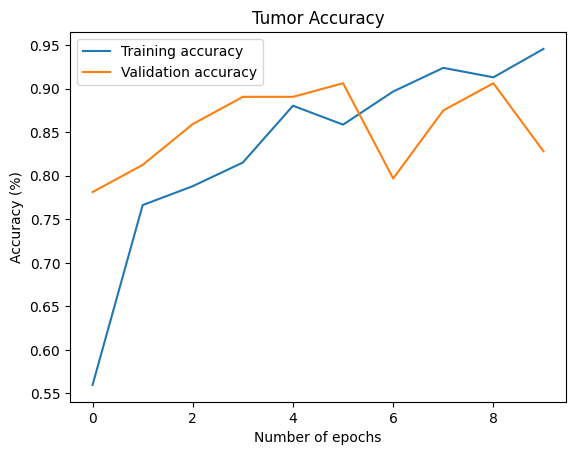

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_accuracies, label='Training accuracy')
plt.plot(valid_accuracies, label='Validation accuracy')
plt.xlabel("Number of epochs")
plt.ylabel("Accuracy (%)")
plt.title("Tumor Accuracy")
plt.legend()
plt.show()

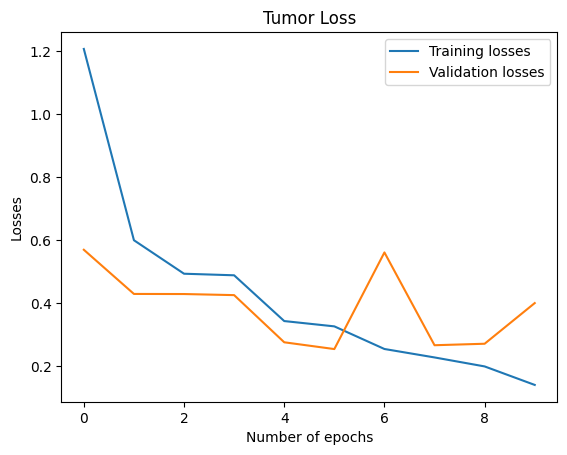

In [ ]:
plt.plot(train_losses, label='Training losses')
plt.plot(valid_losses, label='Validation losses')
plt.xlabel("Number of epochs")
plt.ylabel("Losses")
plt.title("Tumor Loss")
plt.legend()
plt.show()

In [ ]:
#cp /content/model_weights.pth /content/gdrive/MyDrive/Data/

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)


for images, labels in test_dataloader:

    images = images.to(device)
    outputs = model(images)
    predicted_classes = torch.round(torch.sigmoid(outputs))
    print(predicted_classes)

tensor([[0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.]], device='cuda:0', grad_fn=<RoundBackward0>)
tensor([[1.],
        [0.],
        [1.],
        [1.],
        [1.]], device='cuda:0', grad_fn=<RoundBackward0>)


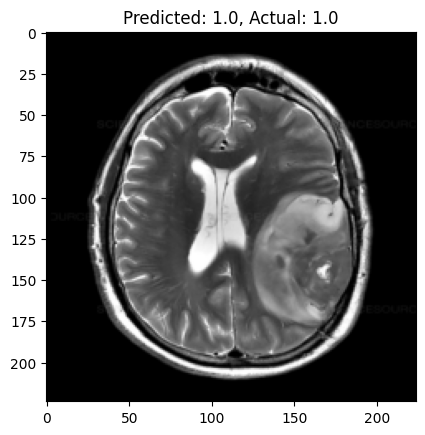

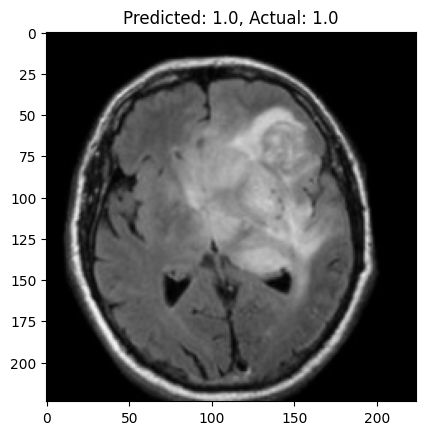

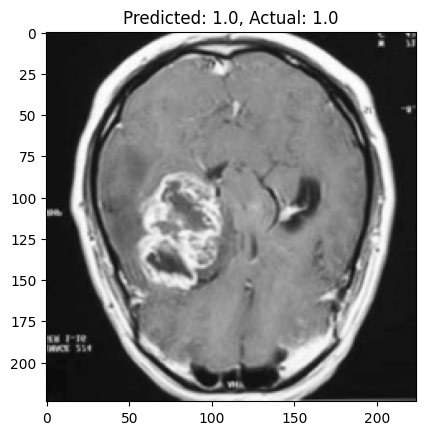

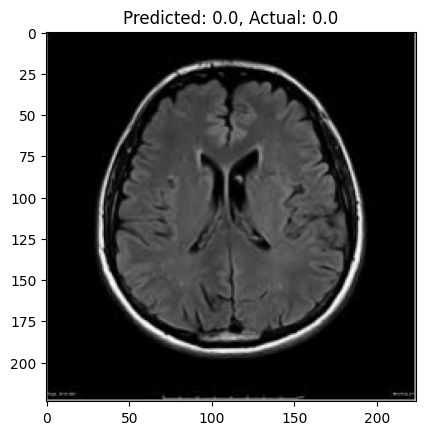

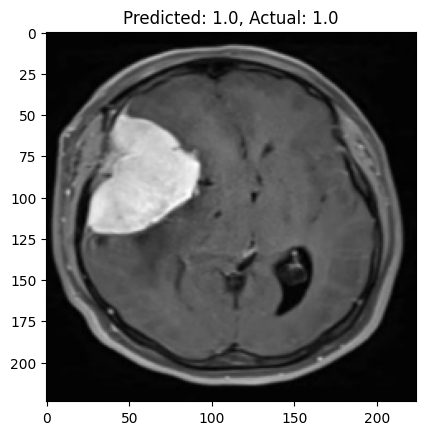

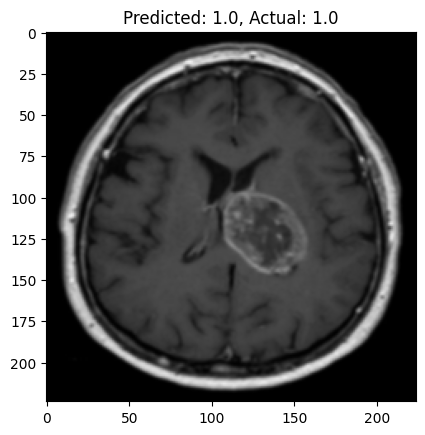

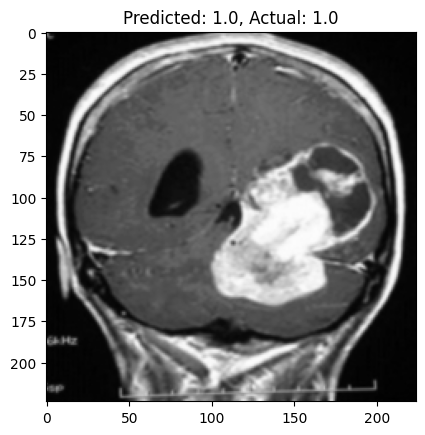

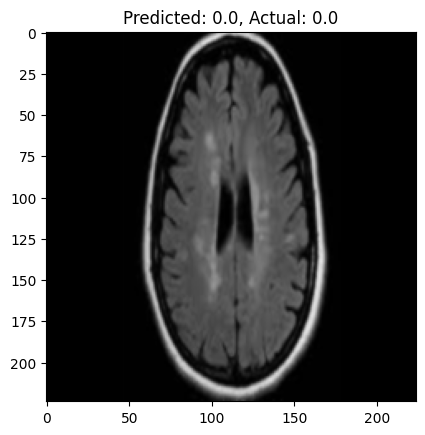

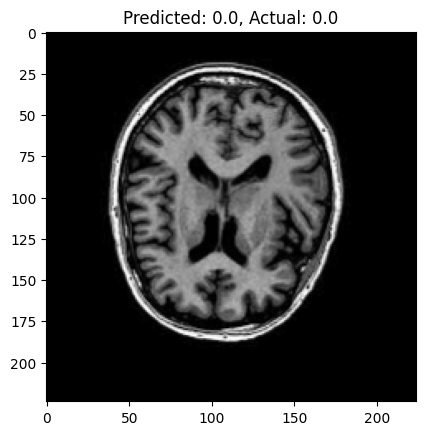

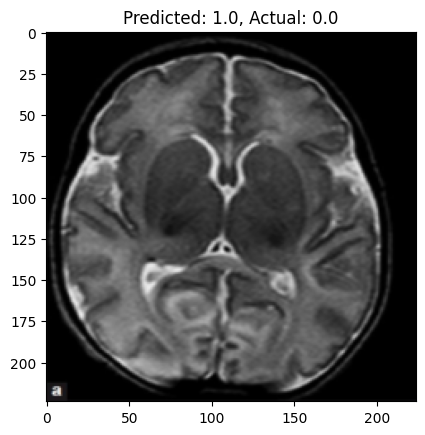

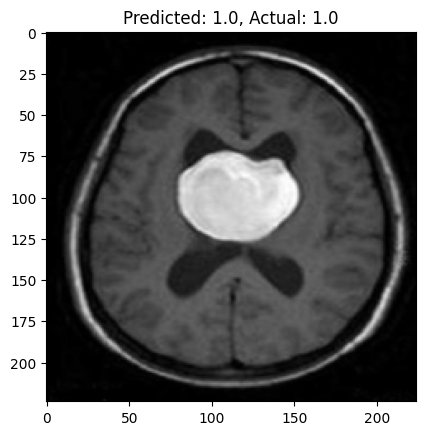

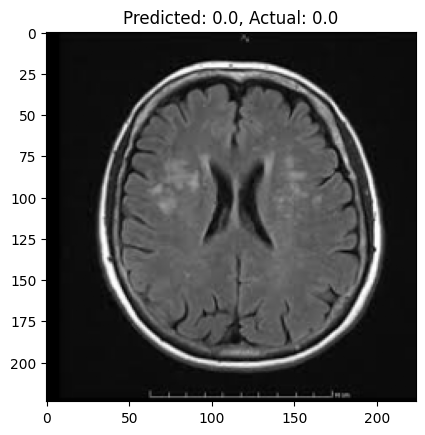

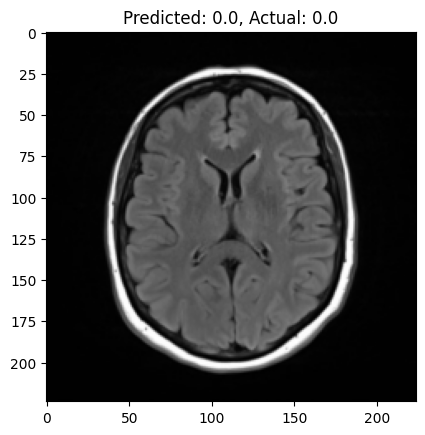

In [ ]:
import matplotlib.pyplot as plt

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)


for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)

    outputs = model(images)
    predicted_classes = torch.round(torch.sigmoid(outputs)).squeeze().item()

    plt.imshow(images.squeeze().permute(1, 2, 0).cpu().numpy())
    plt.title(f'Predicted: {predicted_classes}, Actual: {labels.item()}')
    plt.show()

In [ ]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)

true_positives = 0
false_positives = 0
false_negatives = 0

for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)

    outputs = model(images)
    predicted_classes = torch.round(torch.sigmoid(outputs)).squeeze().item()

    if predicted_classes == 1 and labels.item() == 1:
        true_positives += 1
    elif predicted_classes == 1 and labels.item() == 0:
        false_positives += 1
    elif predicted_classes == 0 and labels.item() == 1:
        false_negatives += 1

precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
f1_score = 2 * (precision * recall) / (precision + recall)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1_score:.4f}")

Precision: 1.0000
Recall: 1.0000
F1-score: 1.0000
